In [49]:
# Functions & Arrays
import numpy as np
# DataFrame
import pandas as pd
# Basic Statistics
import statsmodels.tsa.stattools as stat
import statsmodels.stats.diagnostic as dig

import scipy
from scipy import stats
import scipy.stats as st

# GARCH
from arch import arch_model
# Graphics
from matplotlib import pyplot as plt

In [50]:
# Datas de início e fim para as séries que serão coletadas
data_inicial = '01/01/2017'
data_final = '31/12/2018'

In [51]:
# Funçnao para criar DataFrame por API
def serie(numero, DataInicial = data_inicial, DataFinal = data_final):
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=csv&&dataInicial={}&dataFinal={}'.format(numero, data_inicial, data_final)
    return(pd.read_csv(url, sep = ';', index_col = 0, decimal = ','))
# Criação dos DataFrames das variáveis
PTAX = serie(1)
Selic = serie(11)
DI = serie(12)

In [52]:
# Função para criar gráfico da variável
def graph(df, name):
    df.plot(figsize = (18,9))
    plt.xlabel('Date')
    plt.ylabel(name)
    plt.grid(which = 'both', axis = 'x')
    plt.show()

In [53]:
import matplotlib.dates as dt

In [54]:
def graphi(df, name):
    ax = plt.subplots(1, 1)
    ax.plot(df.valor, index=df.index)
    yloc = dt.YearLocator()
    mloc = dt.MonthLocator()
    ax.xaxis.set_major_locator(yloc)
    ax.xaxis.set_minor_locator(mloc)
    ax.grid(True)
    plt.show()

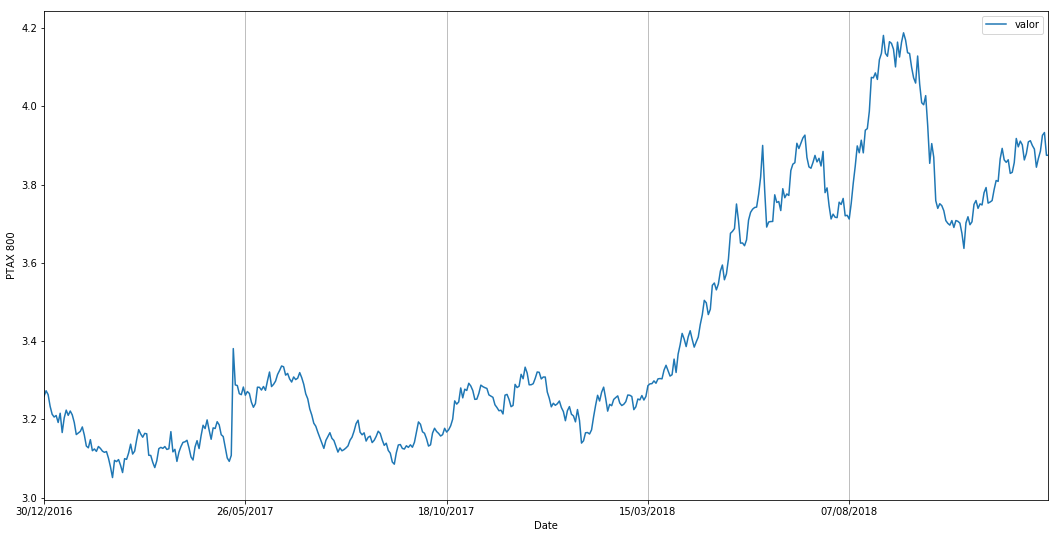

In [55]:
graph(PTAX, 'PTAX 800')

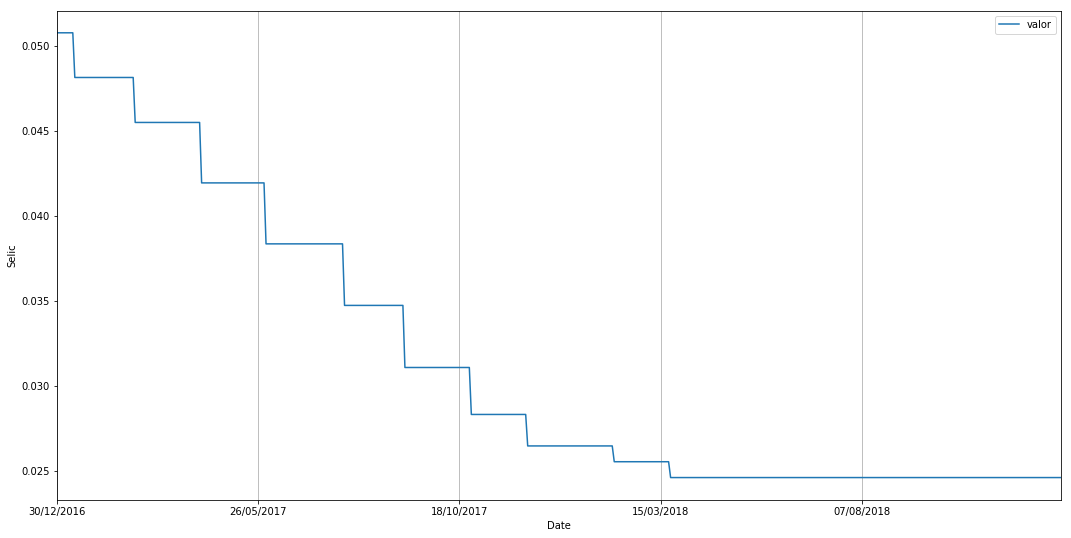

In [56]:
graph(Selic, 'Selic')

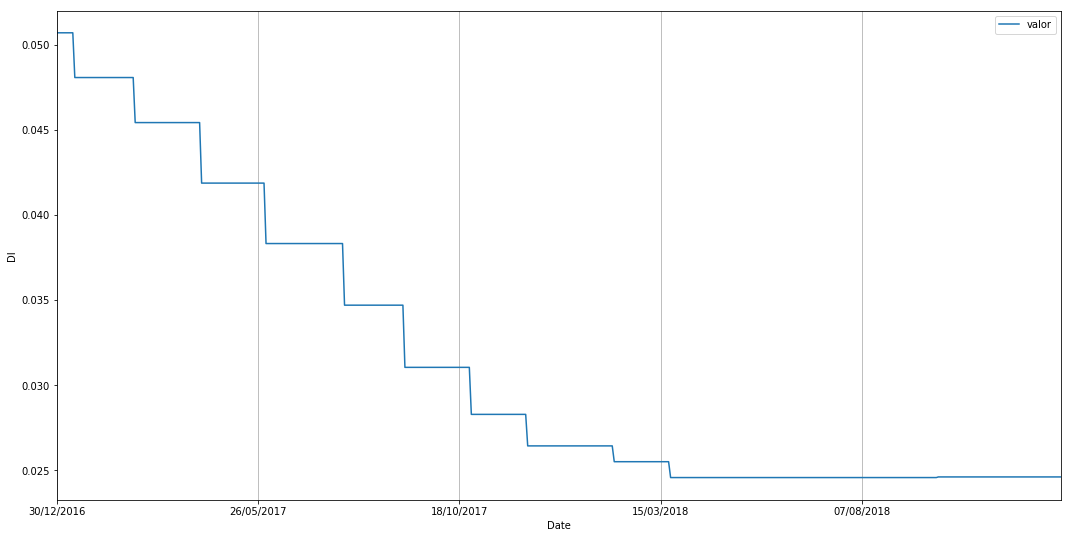

In [57]:
graph(DI, 'DI')

In [58]:
def des_adf_kpss(variables = [], names = []):
    a = ''
    a += '---Descriptive Statistics---'
    for i in range(len(variables)):
        var = variables[i]
        a += '\n{}: mean = {}, standard deviation = {}, minimum = {}, maximum = {}'.format(names[i],
                                                                                 var.mean()[0],
                                                                                 var.std()[0],
                                                                                 var.min()[0],
                                                                                 var.max()[0])     
    a += '\n'
    a += '\n---Augmented Dickey-Fuller---'
    for i in range(len(variables)):
        adf = stat.adfuller(variables[i].valor)
        a += '\n{}: test statistic = {}, critical value at 5% level = {}'.format(names[i],
                                                                                  adf[0],
                                                                                  adf[4]['5%'])
    a += '\n'
    a += '\n---Kwiatkowski–Phillips–Schmidt–Shin---'
    for i in range(len(variables)):
        kpss = stat.kpss(variables[i].valor)
        a += '\n{}: test statistic = {}, critical value at 5% level = {}'.format(names[i],
                                                                                  kpss[0],
                                                                                  kpss[3]['5%'])
    print(a)

In [59]:
des_adf_kpss([PTAX, Selic, DI], ['PTAX', 'Selic', 'DI'])

---Descriptive Statistics---
PTAX: mean = 3.424298000000001, standard deviation = 0.31470928926471003, minimum = 3.051, maximum = 4.1879
Selic: mean = 0.03151969200000015, standard deviation = 0.008422757269277704, minimum = 0.02462, maximum = 0.050788
DI: mean = 0.03148042399999996, standard deviation = 0.008407369331626892, minimum = 0.024583, maximum = 0.050718

---Augmented Dickey-Fuller---
PTAX: test statistic = -0.6100139765306144, critical value at 5% level = -2.867349510566146
Selic: test statistic = -2.7281763217096113, critical value at 5% level = -2.867349510566146
DI: test statistic = -2.731302013892588, critical value at 5% level = -2.867349510566146

---Kwiatkowski–Phillips–Schmidt–Shin---
PTAX: test statistic = 2.168944999382035, critical value at 5% level = 0.463
Selic: test statistic = 2.392781433662355, critical value at 5% level = 0.463
DI: test statistic = 2.392109798357414, critical value at 5% level = 0.463


/Users/bernardopaulsen/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [60]:
def variacao(a):
    VariacaoValor = []
    VariacaoData = []
    for i in range(len(a.valor)):
        if i >= 1:
            valor = a.valor[i]/a.valor[i-1]-1
            VariacaoValor.append(valor)
            VariacaoData.append(a.index[i])
    v = {'valor': VariacaoValor}        
    Variacao = pd.DataFrame(v, index = VariacaoData)
    return(Variacao)

In [61]:
PTAXvar = variacao(PTAX)
Selicvar = variacao(Selic)
DIvar = variacao(DI)

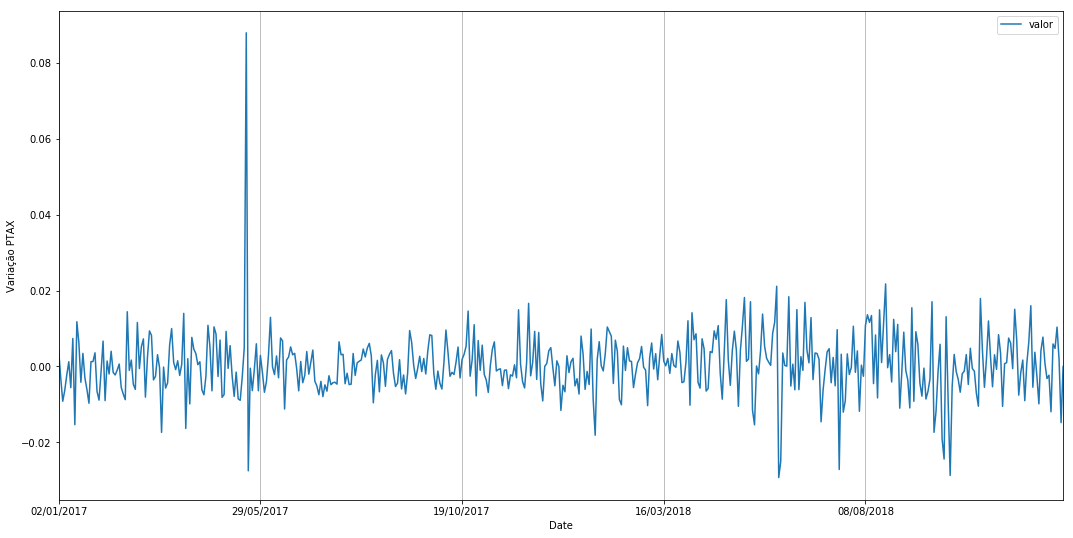

In [62]:
graph(PTAXvar, 'Variação PTAX')

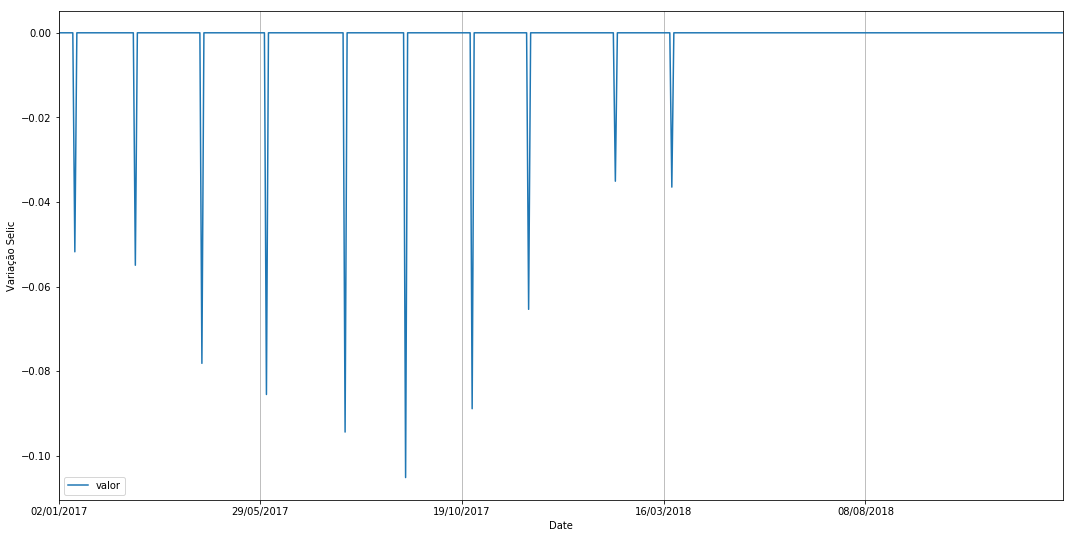

In [63]:
graph(Selicvar, 'Variação Selic')

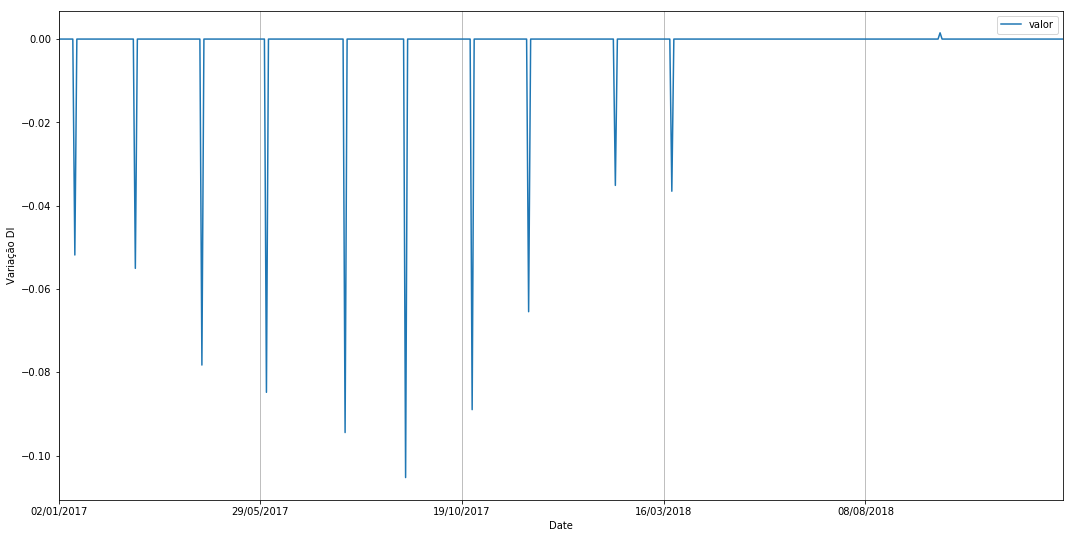

In [64]:
graph(DIvar, 'Variação DI')

In [65]:
def cupom_cambial(juros, usd = PTAX):
    CupomCambialValor = []
    CupomCambialData = []
    for i in range(len(usd.valor)):
        if i >= 1:
            valor = (1+ juros.valor[i]/100)/(usd.valor[i]/usd.valor[i-1])-1
            CupomCambialValor.append(valor)
            CupomCambialData.append(usd.index[i])
    v = {'valor': CupomCambialValor}        
    CupomCambial = pd.DataFrame(v, index = CupomCambialData)
    return(CupomCambial)

In [66]:
CCOC = cupom_cambial(Selic)
CCDI = cupom_cambial(DI)

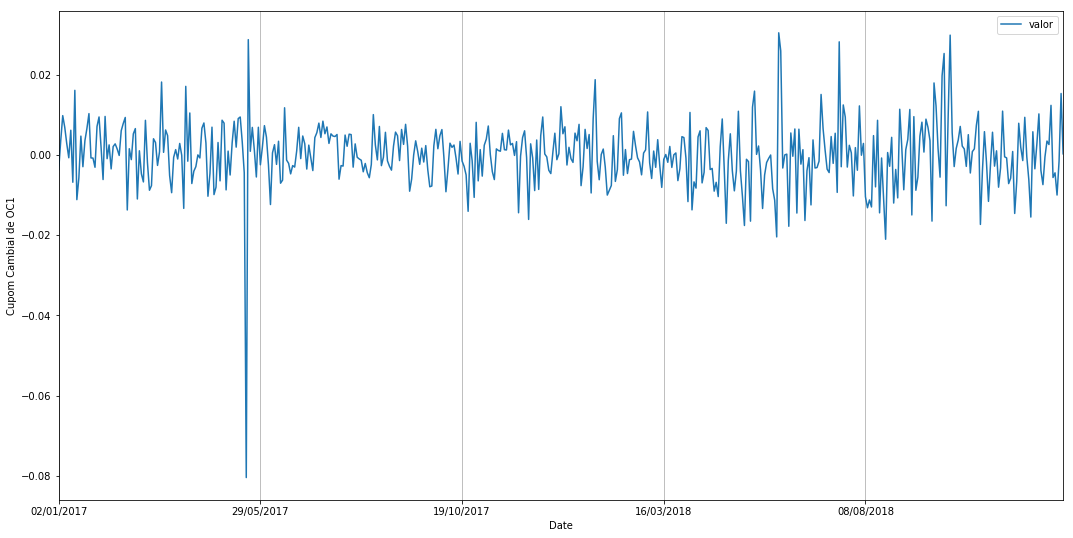

In [67]:
graph(CCOC, 'Cupom Cambial de OC1')

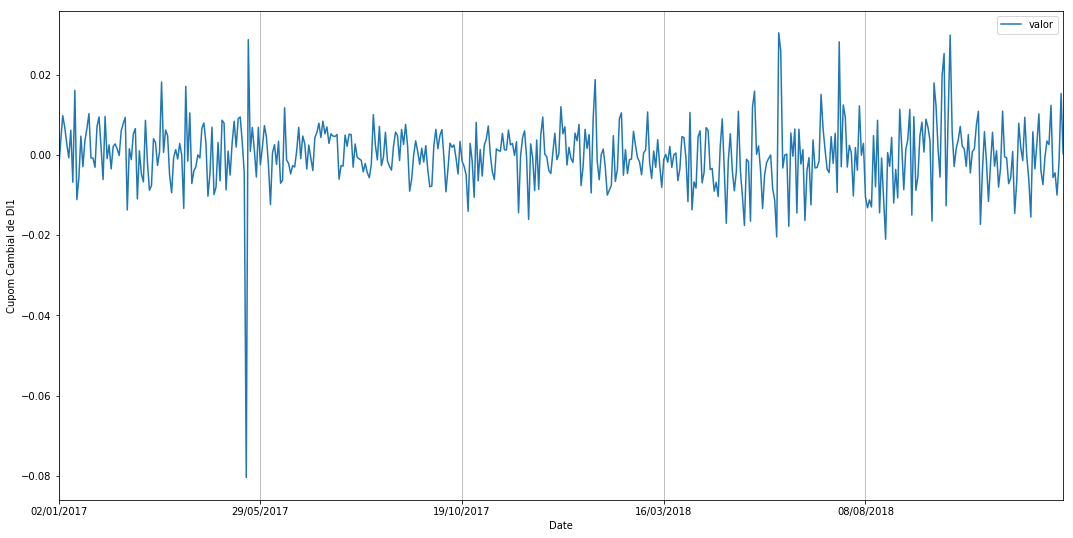

In [68]:
graph(CCDI, 'Cupom Cambial de DI1')

In [69]:
des_adf_kpss([CCOC, CCDI],['Cupom Cambial de OC1', 'Cupom Cambial de DI1'])

---Descriptive Statistics---
Cupom Cambial de OC1: mean = 2.375953081522873e-06, standard deviation = 0.008265001034093269, minimum = -0.08039641029017663, maximum = 0.030391764177606362
Cupom Cambial de DI1: mean = 1.9840252394774735e-06, standard deviation = 0.008264997570992487, minimum = -0.08039706293489524, maximum = 0.030391383026492802

---Augmented Dickey-Fuller---
Cupom Cambial de OC1: test statistic = -17.091297354882528, critical value at 5% level = -2.867372960189225
Cupom Cambial de DI1: test statistic = -17.091295097489578, critical value at 5% level = -2.867372960189225

---Kwiatkowski–Phillips–Schmidt–Shin---
Cupom Cambial de OC1: test statistic = 0.16088747629370279, critical value at 5% level = 0.463
Cupom Cambial de DI1: test statistic = 0.16081173266722162, critical value at 5% level = 0.463


/Users/bernardopaulsen/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [70]:
def total(v):
    valore = []
    data = []
    t = 1
    d = ''
    for i in range(len(v.valor)):
        t = t*(1+v.valor[i])
        valore.append(t)
        data.append(v.index[i])
    va = {'valor': valore}        
    T = pd.DataFrame(va, index = data)
    return(T)

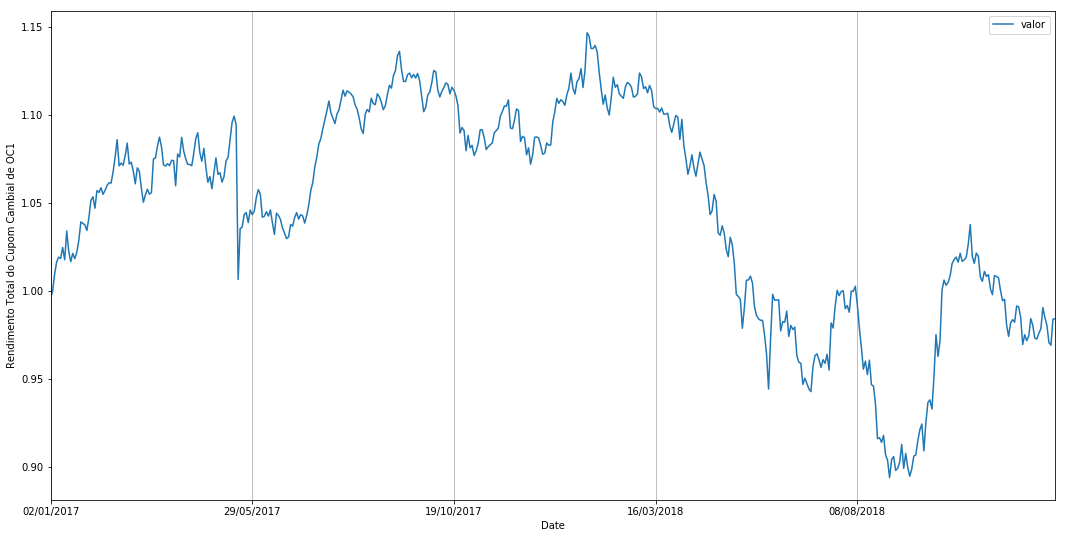

In [71]:
graph(total(CCOC), 'Rendimento Total do Cupom Cambial de OC1')

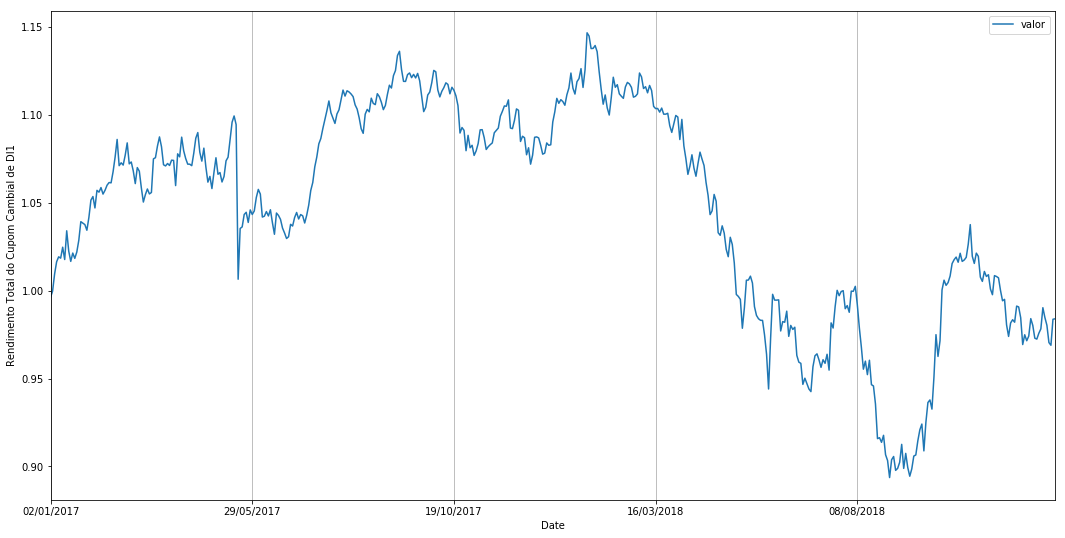

In [72]:
graph(total(CCDI), 'Rendimento Total do Cupom Cambial de DI1')

In [73]:
GarchOC = arch_model(CCOC.valor)
ResultadoGarchOC = GarchOC.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -1695.0599781453138
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1695.1572495579312
Iteration:      3,   Func. Count:     31,   Neg. LLF: -1695.1573705688486
Iteration:      4,   Func. Count:     44,   Neg. LLF: -1695.1574720134993
Iteration:      5,   Func. Count:     54,   Neg. LLF: -1695.1681759274961
Iteration:      6,   Func. Count:     64,   Neg. LLF: -1695.1735343643657
Iteration:      7,   Func. Count:     73,   Neg. LLF: -1695.1801160979153
Iteration:      8,   Func. Count:     86,   Neg. LLF: -1695.1803361324255
Iteration:      9,   Func. Count:     98,   Neg. LLF: -1695.1803733257584
Iteration:     10,   Func. Count:    111,   Neg. LLF: -1695.180405192249
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1695.180405259488
            Iterations: 14
            Function evaluations: 111
            Gradient evaluations: 10


/Users/bernardopaulsen/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [74]:
GarchDI = arch_model(CCDI.valor)
ResultadoGarchDI = GarchDI.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -1695.0600567021638
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1695.1573123772882
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1695.159138521958
Iteration:      4,   Func. Count:     42,   Neg. LLF: -1695.1610095769393
Iteration:      5,   Func. Count:     54,   Neg. LLF: -1695.1610200450573
Iteration:      6,   Func. Count:     67,   Neg. LLF: -1695.1610319356498
Iteration:      7,   Func. Count:     79,   Neg. LLF: -1695.1610359006054
Iteration:      8,   Func. Count:     91,   Neg. LLF: -1695.1610437853196
Iteration:      9,   Func. Count:    103,   Neg. LLF: -1695.1610461219675
Iteration:     10,   Func. Count:    113,   Neg. LLF: -1695.1798115451707
Iteration:     11,   Func. Count:    121,   Neg. LLF: -1695.328088823953
Iteration:     12,   Func. Count:    134,   Neg. LLF: -1695.3837432075136
Iteration:     13,   Func. Count:    143,   Neg. LLF: -1695.3876490750472
Iteration:     14,   Func. Count:    153

/Users/bernardopaulsen/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


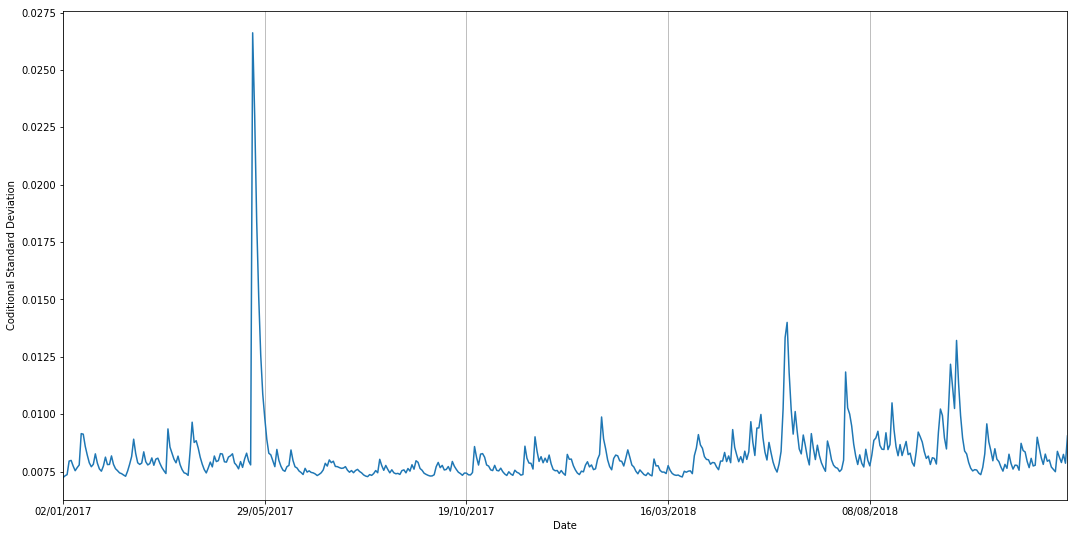

In [116]:
graph(ResultadoGarchOC.conditional_volatility, 'Coditional Standard Deviation')

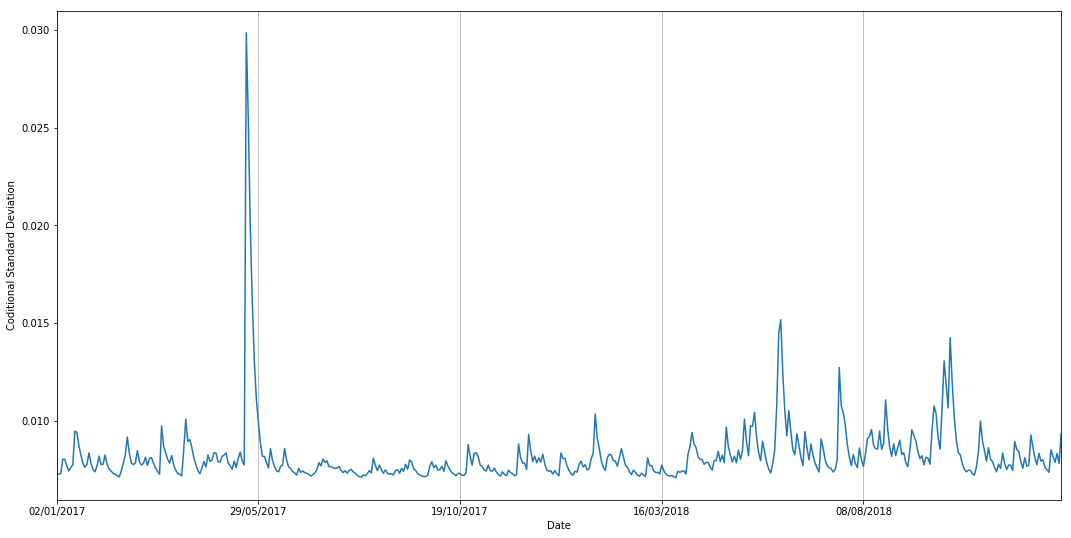

In [117]:
graph(ResultadoGarchDI.conditional_volatility, 'Coditional Standard Deviation')

In [114]:
def des(variables = [], names = []):
    a = ''
    a += '---Descriptive Statistics---'
    for i in range(len(variables)):
        var = variables[i]
        a += '\n{}: mean = {}, standard deviation = {}, minimum = {}, maximum = {}'.format(names[i],
                                                                                 var.mean(),
                                                                                 var.std(),
                                                                                 var.min(),
                                                                                 var.max())
    print(a)

In [115]:
des([ResultadoGarchOC.conditional_volatility, ResultadoGarchDI.conditional_volatility],['Cupom Cambial de OC1', 'Cupom Cambial de DI1'])

---Descriptive Statistics---
Cupom Cambial de OC1: mean = 0.008188606415006659, standard deviation = 0.001474871417161449, minimum = 0.007242569790217517, maximum = 0.026617841724520665
Cupom Cambial de DI1: mean = 0.008223064111934781, standard deviation = 0.0017346317324921873, minimum = 0.007104274661718949, maximum = 0.029855189664593412


In [127]:
def lim(v):
    mais = []
    menos = []
    data = []
    for i in range(len(v.values)):
        mais.append(v.mean()+2*v.std())
        menos.append(v.mean()-2*v.std())
        data.append(v.index[i])
    va = {'Upper_Limit': mais, 'Lower_Limit': menos}        
    T = pd.DataFrame(va, index = data)
    return(T)

In [128]:
LimOC = lim(ResultadoGarchOC.conditional_volatility)
LimDI = lim(ResultadoGarchDI.conditional_volatility)

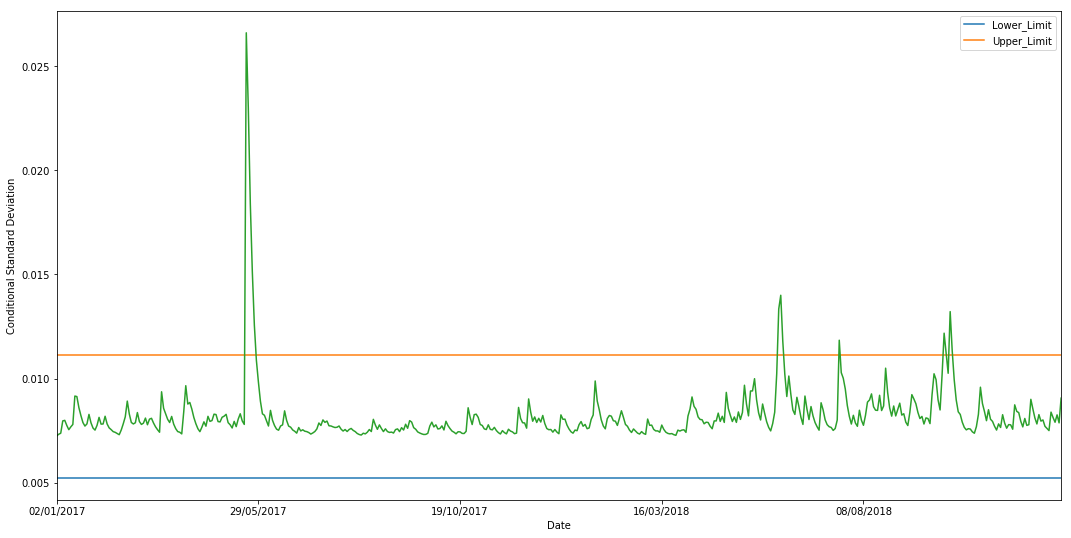

In [131]:
LimOC.plot(figsize = (18,9))
plt.xlabel('Date')
plt.ylabel('Conditional Standard Deviation')
ResultadoGarchOC.conditional_volatility.plot(figsize = (18,9))
plt.show()

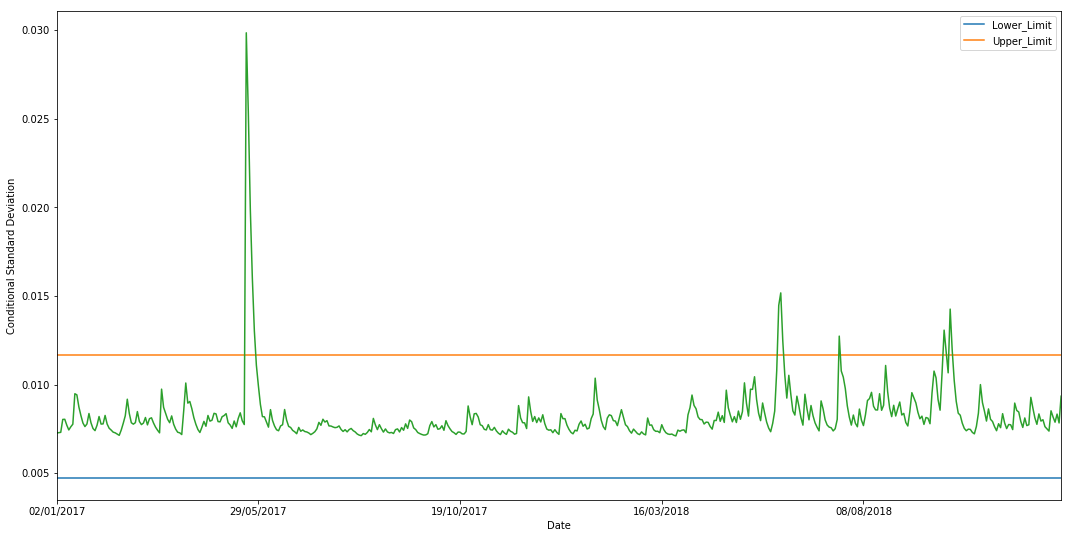

In [132]:
LimDI.plot(figsize = (18,9))
plt.xlabel('Date')
plt.ylabel('Conditional Standard Deviation')
ResultadoGarchDI.conditional_volatility.plot(figsize = (18,9))
plt.show()

In [138]:
def maior(resultado, l, nome):
    datas = []
    n = 0
    s = '---Dates with Abnormal Volatility for {}---'.format(nome)
    for i in range(len(l.index)):
        if resultado[i] > l.Upper_Limit[i]:
            datas.append(l.index[i])
            n += 1
        elif resultado[i] < l.Lower_Limit[i]:
            n += 1
            datas.append(l.index[i])
    for i in range(len(datas)):
        s += '\nDay number {}: {}'.format((i+1), datas[i])
    s += '\nDays with abnarmal volatility: {}'.format(n)
    print(s)

In [154]:
maior(ResultadoGarchOC.conditional_volatility, lim(ResultadoGarchOC.conditional_volatility), 'OC')

---Dates with Abnormal Volatility for OC---
Day number 1: 19/05/2017
Day number 2: 22/05/2017
Day number 3: 23/05/2017
Day number 4: 24/05/2017
Day number 5: 25/05/2017
Day number 6: 11/06/2018
Day number 7: 12/06/2018
Day number 8: 13/06/2018
Day number 9: 23/07/2018
Day number 10: 04/10/2018
Day number 11: 05/10/2018
Day number 12: 09/10/2018
Day number 13: 10/10/2018
Days with abnarmal volatility: 13


In [155]:
maior(ResultadoGarchDI.conditional_volatility, lim(ResultadoGarchDI.conditional_volatility), 'DI')

---Dates with Abnormal Volatility for DI---
Day number 1: 19/05/2017
Day number 2: 22/05/2017
Day number 3: 23/05/2017
Day number 4: 24/05/2017
Day number 5: 25/05/2017
Day number 6: 11/06/2018
Day number 7: 12/06/2018
Day number 8: 13/06/2018
Day number 9: 23/07/2018
Day number 10: 04/10/2018
Day number 11: 05/10/2018
Day number 12: 09/10/2018
Day number 13: 10/10/2018
Days with abnarmal volatility: 13


In [156]:
def limite(v):
    mais = []
    menos = []
    data = []
    maior = v.mean() + (stats.norm.ppf(q = 0.975) * (v.std()))
    menor = v.mean() - (stats.norm.ppf(q = 0.975) * (v.std()))
    for i in range(len(v.values)):
        mais.append(maior)
        menos.append(menor)
        data.append(v.index[i])
    va = {'Upper_Limit': mais, 'Lower_Limit': menos}        
    T = pd.DataFrame(va, index = data)
    return(T)

In [157]:
LimiteOC = limite(ResultadoGarchOC.conditional_volatility)
LimiteDI = limite(ResultadoGarchDI.conditional_volatility)

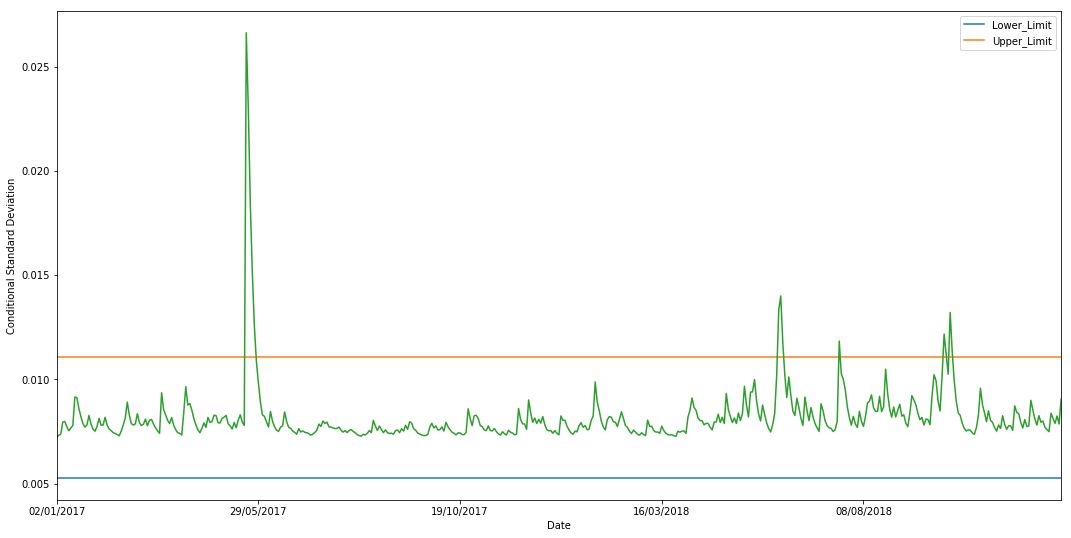

In [148]:
LimiteOC.plot(figsize = (18,9))
plt.xlabel('Date')
plt.ylabel('Conditional Standard Deviation')
ResultadoGarchOC.conditional_volatility.plot(figsize = (18,9))
plt.show()

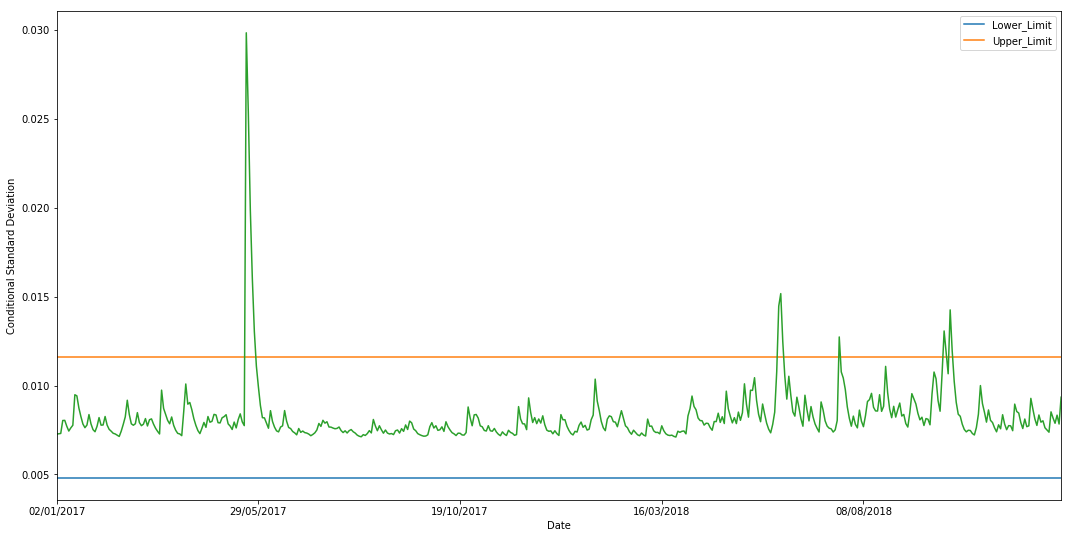

In [136]:
LimiteDI.plot(figsize = (18,9))
plt.xlabel('Date')
plt.ylabel('Conditional Standard Deviation')
ResultadoGarchDI.conditional_volatility.plot(figsize = (18,9))
plt.show()

In [141]:
maior(ResultadoGarchOC.conditional_volatility, limite(ResultadoGarchOC.conditional_volatility), 'OC')

---Dates with Abnormal Volatility for OC---
Day number 1: 19/05/2017
Day number 2: 22/05/2017
Day number 3: 23/05/2017
Day number 4: 24/05/2017
Day number 5: 25/05/2017
Day number 6: 11/06/2018
Day number 7: 12/06/2018
Day number 8: 13/06/2018
Day number 9: 23/07/2018
Day number 10: 04/10/2018
Day number 11: 05/10/2018
Day number 12: 09/10/2018
Day number 13: 10/10/2018
Days with abnarmal volatility: 13


In [142]:
maior(ResultadoGarchDI.conditional_volatility, limite(ResultadoGarchDI.conditional_volatility), 'OC')

---Dates with Abnormal Volatility for OC---
Day number 1: 19/05/2017
Day number 2: 22/05/2017
Day number 3: 23/05/2017
Day number 4: 24/05/2017
Day number 5: 25/05/2017
Day number 6: 11/06/2018
Day number 7: 12/06/2018
Day number 8: 13/06/2018
Day number 9: 23/07/2018
Day number 10: 04/10/2018
Day number 11: 05/10/2018
Day number 12: 09/10/2018
Day number 13: 10/10/2018
Days with abnarmal volatility: 13


In [90]:
def ljung_shapiro(variables = [], names = []):
    a = ''
    a += '---Ljung-Box Test---'
    for i in range(len(variables)):
        var = variables[i]
        a += '\n{}: p-value = {}'.format(names[i],
                                         dig.acorr_ljungbox(var, lags=1)[1][0],
                                        )     
    a += '\n'
    a += '\n---Shpairo-Wilk Test---'
    for i in range(len(variables)):
        var = variables[i]
        a += '\n{}: p-value = {}'.format(names[i],
                                         scipy.stats.shapiro(var)[1],
                                        )
    print(a)

In [91]:
ljung_shapiro([ResultadoGarchOC.resid, ResultadoGarchDI.resid], ['Resíduos GARCH OC1', 'Resíduos GARCH DI1'])

---Ljung-Box Test---
Resíduos GARCH OC1: p-value = 0.4705183276708006
Resíduos GARCH DI1: p-value = 0.47052044917263636

---Shpairo-Wilk Test---
Resíduos GARCH OC1: p-value = 1.5640072528211224e-18
Resíduos GARCH DI1: p-value = 1.5634680344593144e-18


In [92]:
def graphs(var = [], name = [], n = 1):
    n = len(var)
    fig, axs = plt.subplots(nrows=n, figsize=((n*9), 18))
    for i in range(len(var)):
        ax = axs[i]
        ax.plot(var[i].valor)
        ax.set_title(name[i])
    plt.show()